In [1]:
cd /content/drive/My Drive/Colab Notebooks/ImageProcessing_Assignment.zip (Unzipped Files)/assignment

/content/drive/My Drive/Colab Notebooks/ImageProcessing_Assignment.zip (Unzipped Files)/assignment


In [ ]:
pip install -U scikit-image

In [3]:
import numpy as np
from scipy.ndimage import rotate
import os
from PIL import Image
import math
import cv2 as cv
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import correlate, convolve
from skimage import data
from skimage.util import img_as_ubyte
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from exGenerator import *
matricola = '1747042'

In [4]:
imm1, imm2, imm3, imm4 = ex11(matricola)

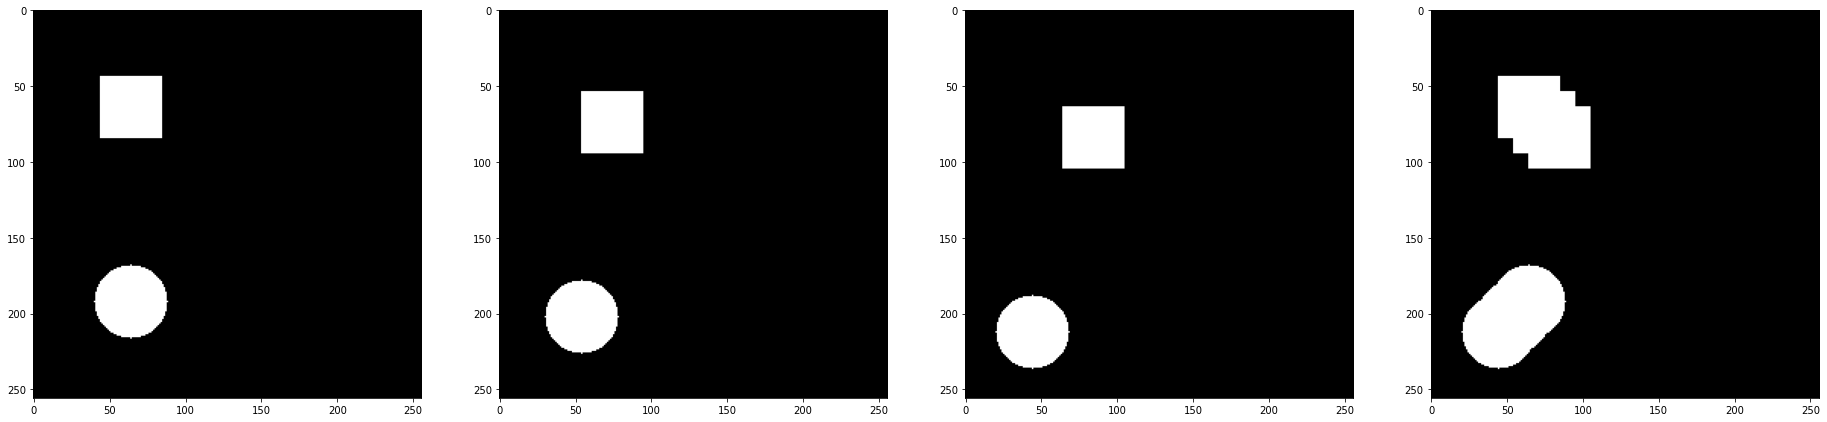

In [5]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(141), plt.imshow(imm1, "gray")
plt.subplot(142), plt.imshow(imm2, "gray")
plt.subplot(143), plt.imshow(imm3, "gray")
plt.subplot(144), plt.imshow(imm4, "gray")

plt.show()

SEGMENTATION

In [6]:
def copyof(img):
  copy = np.zeros((np.size(img, 0),np.size(img, 1)))
  for x in range(np.size(img, 0)):
    for y in range(np.size(img, 1)):
      copy[x][y] = img[x][y]
  return copy

In [7]:
#find the two most distant points
def maxdst2point(m):
  copy = copyof(m)
  find = False
  point = []
  for x in range(1, np.size(copy, 0) - 1, 1):
    for y in range(1, np.size(copy, 1) - 1, 1):
      if (copy[x][y] == 1):
        point.append([x,y])
        find = True
        break
    if (find):
      break

  dstMax = 0
  xMax = 0
  yMax = 0
  for x in range(np.size(copy, 0)):
    for y in range(np.size(copy, 1)):
      if ([x, y] in point):
        continue
      if (copy[x][y] == 1.0):
        dst = np.sqrt(np.square(point[0][0] - x) + np.square(point[0][1] - y))
        if (dst > dstMax):
          dstMax = dst
          xMax = x
          yMax = y
  point.append([xMax,yMax])
  return point

In [8]:
#1 cycle of kmeans
def segmentation(m):
  seed = maxdst2point(m)
  figures = []
  figures.append([])
  figures.append([])
  for x in range(np.size(m, 0)):
    for y in range(np.size(m, 1)):
      if (m[x][y] == 1.0):
        dst1 = np.sqrt(np.square(seed[0][0] - x) + np.square(seed[0][1] - y))
        dst2 = np.sqrt(np.square(seed[1][0] - x) + np.square(seed[1][1] - y))
        if (dst1 > dst2):
          figures[0].append([x,y])
        else:
          figures[1].append([x,y])
  return figures

In [9]:
#create images with a single figure
def figureSeg(segmentation, img):
  segImage = []
  for f in segmentation:
    figure = np.zeros(np.shape(img))
    for i in range(np.size(img,0)):
      for j in range(np.size(img,1)):
        if ([i,j] in f):
          figure[i][j] = 255
    segImage.append(figure)
  return segImage

In [10]:
# binary image
img1 = np.array(imm1) > 250
img2 = np.array(imm2) > 250
img3 = np.array(imm3) > 250

#figures coordinate
figuresF1 = segmentation(img1)
figuresF2 = segmentation(img2)
figuresF3 = segmentation(img3)

#output figures
segImage1 = figureSeg(figuresF1,img1)
segImage2 = figureSeg(figuresF2,img2)
segImage3 = figureSeg(figuresF3,img3)

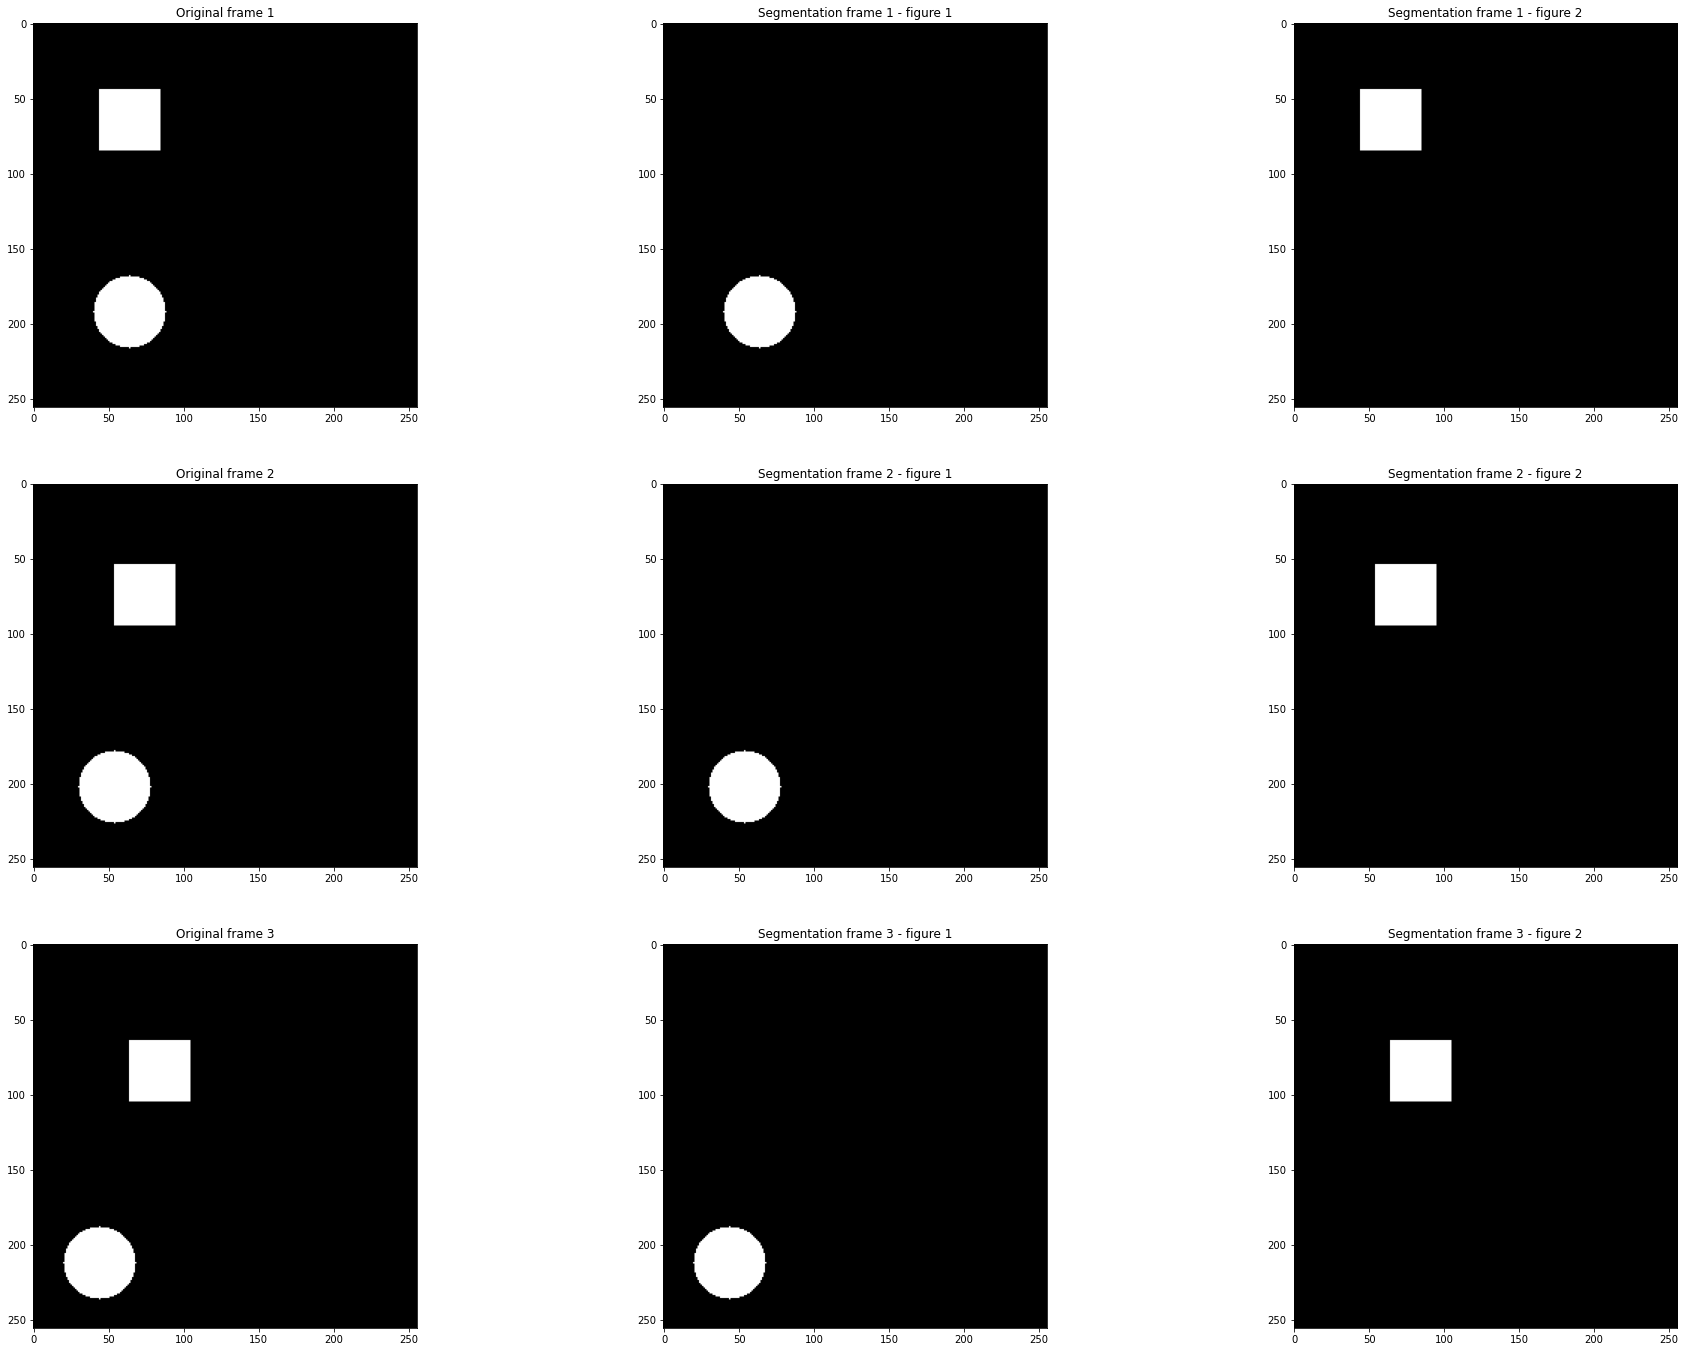

In [11]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(331), plt.imshow(img1, "gray"), plt.title("Original frame 1")
plt.subplot(332), plt.imshow(segImage1[0], "gray"), plt.title("Segmentation frame 1 - figure 1")
plt.subplot(333), plt.imshow(segImage1[1], "gray"), plt.title("Segmentation frame 1 - figure 2")
plt.subplot(334), plt.imshow(img2, "gray"), plt.title("Original frame 2")
plt.subplot(335), plt.imshow(segImage2[0], "gray"), plt.title("Segmentation frame 2 - figure 1")
plt.subplot(336), plt.imshow(segImage2[1], "gray"), plt.title("Segmentation frame 2 - figure 2")
plt.subplot(337), plt.imshow(img3, "gray"), plt.title("Original frame 3")
plt.subplot(338), plt.imshow(segImage3[0], "gray"), plt.title("Segmentation frame 3 - figure 1")
plt.subplot(339), plt.imshow(segImage3[1], "gray"), plt.title("Segmentation frame 3 - figure 2")

plt.show()

OPTICAL FLOW

In [12]:
def opticalFlow(frame1, frame2, r, numvec):
  v, u = optical_flow_ilk(frame1, frame2, radius=r)
  norm = np.sqrt(u**2 + v**2)
  numrow, numcol = frame1.shape
  step = max(numrow//numvec, numcol//numvec)
  y, x = np.mgrid[:numrow:step, :numcol:step]
  ure = u[::step, ::step]
  vre = v[::step, ::step]
  return (x, y, ure, vre, norm)

In [13]:
numvec = 40

#frame 1 to 2
x11, y11, ure11, vre11, norm11 = opticalFlow(segImage1[0], segImage2[0], 20, numvec)
x12, y12, ure12, vre12, norm12 = opticalFlow(segImage1[1], segImage2[1], 20, numvec)

#frame 2 to 3
x21, y21, ure21, vre21, norm21 = opticalFlow(segImage2[0], segImage3[0], 25, numvec)
x22, y22, ure22, vre22, norm22 = opticalFlow(segImage2[1], segImage3[1], 25, numvec)

DISPLAY

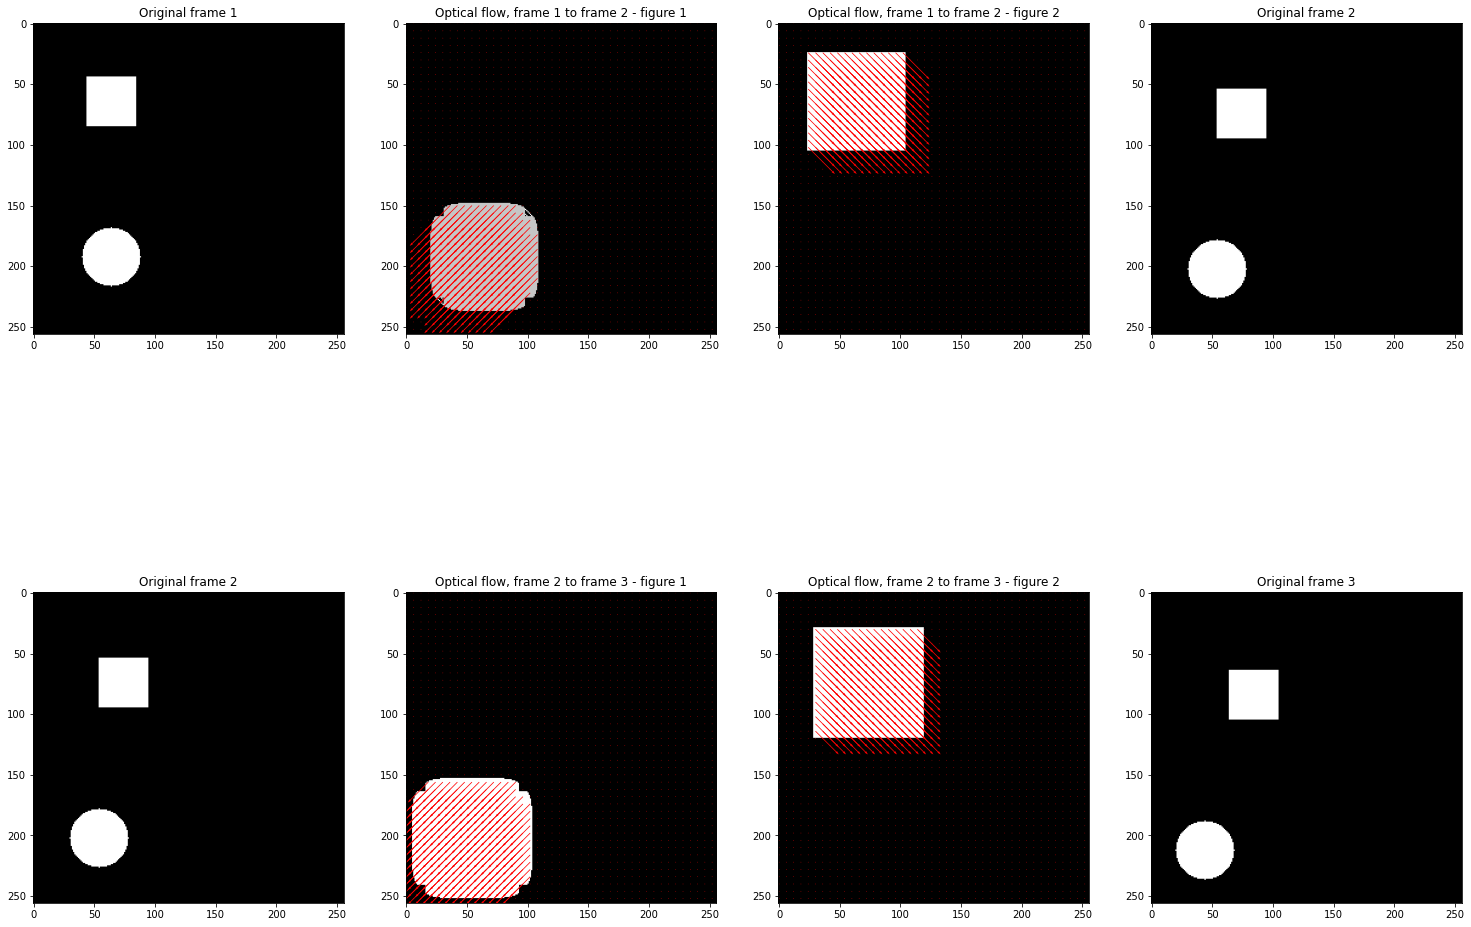

In [14]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

plt.subplot(241), plt.imshow(img1, "gray"), plt.title("Original frame 1")
plt.subplot(242), plt.imshow(norm11, "gray"), plt.quiver(x11, y11, ure11, vre11, color='r', units='dots', angles='xy', scale_units='xy', lw=3), plt.title("Optical flow, frame 1 to frame 2 - figure 1")
plt.subplot(243), plt.imshow(norm12, "gray"), plt.quiver(x12, y12, ure12, vre12, color='r', units='dots', angles='xy', scale_units='xy', lw=3), plt.title("Optical flow, frame 1 to frame 2 - figure 2")
plt.subplot(244), plt.imshow(img2, "gray"), plt.title("Original frame 2")

plt.subplot(245), plt.imshow(img2, "gray"), plt.title("Original frame 2")
plt.subplot(246), plt.imshow(norm21, "gray"), plt.quiver(x21, y21, ure21, vre21, color='r', units='dots', angles='xy', scale_units='xy', lw=3), plt.title("Optical flow, frame 2 to frame 3 - figure 1")
plt.subplot(247), plt.imshow(norm22, "gray"), plt.quiver(x22, y22, ure22, vre22, color='r', units='dots', angles='xy', scale_units='xy', lw=3), plt.title("Optical flow, frame 2 to frame 3 - figure 2")
plt.subplot(248), plt.imshow(img3, "gray"), plt.title("Original frame 3")

plt.show()